In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from copy import deepcopy

from qibo.backends import construct_backend
from qibo import hamiltonians, Circuit, gates, set_backend
from qibo import gates, symbols
from qibo.gates import Unitary, CNOT, CZ
from qibo.symbols import X, Y, Z
from qibo import hamiltonians
from qibo.hamiltonians import Hamiltonian, SymbolicHamiltonian

from db_doi.group_commutator_iteration import GroupCommutatorIteration, DoubleBracketRotationApproximationType
from db_doi.utils_XXZ_compilation import *

/home/marek/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from db_doi.utils_reporting import load_data, loading_simulation_data_path, fidelity_witness, save_data

HVA_results = {}
HVA_energies = load_data(loading_simulation_data_path() + f"energies")
for L in HVA_energies['Ls']:
    HVA_results[L] = load_data(loading_simulation_data_path() + f"XXZ_HVA_data_L{L}")
selected_circuits = load_data(loading_simulation_data_path() + f"selected_HVA_circuits")

In [3]:
L = 20
E0 = HVA_energies['E0_L'][L]
E1 = HVA_energies['E1_L'][L]
if 0: 
    db_doi_hva_results = {}
   
    for p in [1,2,3,4,5,6]:
        db_doi_warmstart_circuit = HVA_results[L][f"HVA_Nlayers_{p}"]['circuit']
        gci = GroupCommutatorIteration(XXZ_compilation_line(L), db_doi_warmstart_circuit, DoubleBracketRotationApproximationType.group_commutator_reduced )
        print(gci.loss(), HVA_results[L][f"HVA_Nlayers_{p}"]['E_HVA'], E0)
        print(gci.double_bracket_rotation_approximation_type)
        from collections import Counter


        doi = hamiltonians.SymbolicHamiltonian( sum([ Z(i) for i in range(L)]))

        gci_results = {}
            
        db_doi_two_qubit_counts = [ two_qubit_counter(db_doi_warmstart_circuit) ]
        db_doi_energies =  [ gci.loss() ]
        db_doi_circuits = [deepcopy(db_doi_warmstart_circuit)]
        db_doi_fidelity_witness = [ fidelity_witness(gci.loss(),E0,E1)]
        for step in range(3):
            print("--------------------------")
            print(f"Step {step+1}")   

            step_grid = np.linspace(0.0005, 0.03, 7)
            s_opt, s_min, losses, _ = gci.choose_step(
                doi, step_grid=step_grid)
            print("Step grid:", step_grid)
            print("Losses:", losses)
            print(f"Optimal step: {s_opt}")
            print(f"Minimum loss: {s_min}")
            plt.figure()
            plt.plot(step_grid, losses, marker='o')
            plt.xlabel('Step size')
            plt.ylabel('Loss')
            plt.title('Loss vs Step size for gci_hva.choose_step')
            plt.show()

            gci(s_opt, doi)

            db_doi_two_qubit_counts.append( two_qubit_counter(gci.preparation_circuit))
            db_doi_energies.append(gci.loss())
            db_doi_circuits.append(deepcopy(gci.preparation_circuit))
            db_doi_fidelity_witness.append(fidelity_witness(gci.loss(),E0,E1))
        db_doi_hva_results[p] = {'energies': db_doi_energies, 
                            'cz_counts': db_doi_two_qubit_counts, 
                            'fidelity_witness':db_doi_fidelity_witness,
                            'circuits': db_doi_circuits}
    save_data(db_doi_hva_results, loading_simulation_data_path()+f"XXZ_DB_DOI_HVA_data_L_{L}")


In [4]:
from db_doi.utils_reporting import *
db_doi_hva_results = load_data( loading_simulation_data_path()+f"XXZ_DB_DOI_HVA_data_L_{L}")

In [5]:
db_doi_hva_results.keys()

dict_keys([1, 2, 3, 4, 5, 6])

<>:29: SyntaxWarning: invalid escape sequence '\h'
<>:29: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_4602/2298466412.py:29: SyntaxWarning: invalid escape sequence '\h'
  ax.set_title("DB-DOI for $L={20}$ qubit $\hat H_{\mathrm{XXX}}$ with HVA warm-start")


[np.float64(-33.811057507777605), np.float64(-34.34553897583189), np.float64(-34.52482487656907), np.float64(-34.59773436094439), np.float64(-34.63561951085654), np.float64(-34.65949516474965)]


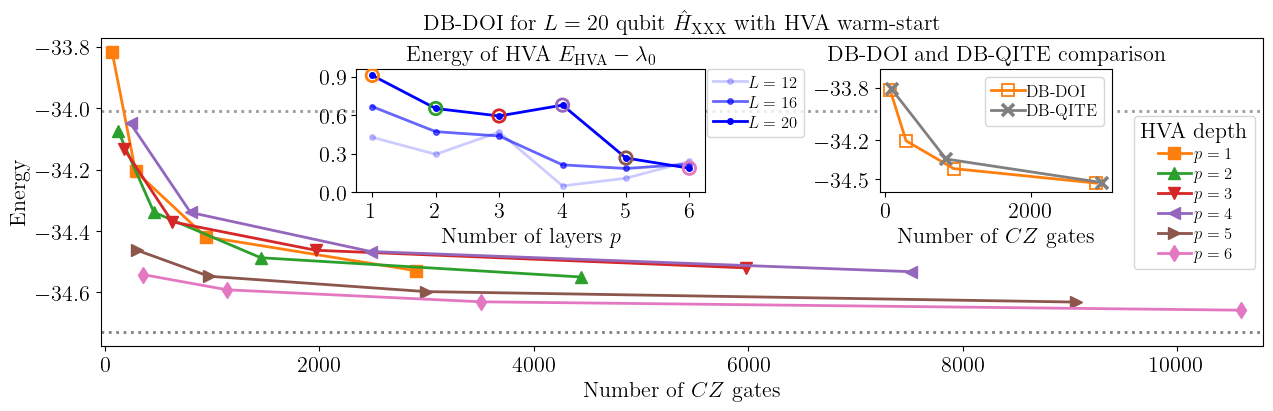

In [122]:
run_param_rc(16)

hva_two_qubit_counts = []
for p in range(1,7):
    hva_two_qubit_counts.append( two_qubit_counter(HVA_results[L][f"HVA_Nlayers_{p}"]['circuit']))

fig, ((ax)) = plt.subplots(1, 1, figsize=(15, 4), 
                                     gridspec_kw={"width_ratios": [1], "height_ratios": [1]})
markers = ['o', 's', '^', 'v', '<', '>', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

steps = [1,2,3,4,5,6]
#ax0.plot(steps, E_HVA_L[L]-E0_L[L], color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")

i=0


#ax.plot(hva_two_qubit_counts, HVA_energies['E_HVA_L'][L], color=colors[i], marker=markers[i], linestyle='solid', label = rf"HVA $L={L}$")
ax.axhline(y=E0, color="black", linestyle=':', alpha=0.5)
ax.axhline(y=E1, color="black", linestyle=':', alpha=0.4)
ax.set_xlabel(r"Number of $CZ$ gates")
#ax.grid()
ax.set_ylabel(r"Energy")

for p in [1,2,3,4,5,6]:
    db_doi_energies = db_doi_hva_results[p]['energies']
    db_doi_two_qubit_counts = db_doi_hva_results[p]['cz_counts']
    ax.plot(db_doi_two_qubit_counts, db_doi_energies, color=colors[p], marker=markers[p], linestyle='solid', label = rf"$p={p}$")
ax.set_title("DB-DOI for $L={20}$ qubit $\hat H_{\mathrm{XXX}}$ with HVA warm-start")



ax.legend(title="HVA depth")#bbox_to_anchor=(1.05, 1), loc='upper left')

ax0 = ax.inset_axes([0.22, 0.5, 0.3, 0.4]) # x=0.65, y=0.55, width=0.3, height=0.4

E_HVA_L = HVA_energies['E_HVA_L']
E0_L = HVA_energies['E0_L']
F_W_L = HVA_energies['F_W_L']

markers = ['o', 's', '^', 'v', '<', '>', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
alphas = np.linspace(0.2,1,3)
markers2 = ['o','h','H']
for i,L in enumerate([12,16,20]):    
    steps = [1,2,3,4,5,6]
    ax0.plot(steps, E_HVA_L[L]-E0_L[L], color='blue', alpha = alphas[i], markersize = 4, marker=markers[0], linestyle='solid', label = rf"$L={L}$")
ax0.set_xlabel(r"Number of layers $p$")
ax0.set_title(r"Energy of HVA $E_{\mathrm{HVA}}-\lambda_0$")

for p,E  in zip(steps, E_HVA_L[20]):
        ax0.scatter(p,E-E0_L[selection["L"]],
                facecolors='none',   # No fill inside the circle
                edgecolors=colors[p],    # Red outline for the circle
                marker='o',          # Circle marker
                s=80,               # Size of the circle (adjust as needed)
                linewidth=2,         # Thickness of the circle's outline
                zorder=5)            # Ensure it's drawn on top


#inset_ax1.plot(x_inset1, y_inset1, 'r-o', markersize=3)
#ax0.set_title('HVA performance')
ax0.set_yticks([0, 0.3,0.6,0.9])
ax0.set_ylim([0,0.96])
ax0.set_xticks([1,2,3,4,5,6])
ax0.tick_params(axis='both', which='minor', labelsize=6)
#inset_ax1.grid(True, linestyle=':', alpha=0.6)
ax0.legend(bbox_to_anchor=(.98, 1.07), loc='upper left')
# --- 5. Add the second inset next to the first one ---
ax2 = ax.inset_axes([0.67, 0.5, 0.2, 0.4]) # x=0.35, y=0.55, width=0.3, height=0.4
path = "../simulation_results/Qrisp_simulations_DB_QITE_and_QPE/data/benchmarks_2nd_L=20_05-21-22"

#path = "../simulation_results/Qrisp_simulations_DB_QITE_and_QPE/data/benchmarks_2nd_L=10_05-21-16"
db_qite_simulation_results = load_data(path)
print(db_qite_simulation_results[1]['optimal_energies'])
db_qite_two_qubit_counts = [db_qite_simulation_results[1]['circuit_data'][0][k]['cz'] for k in range(6)]
db_qite_energies = db_qite_simulation_results[1]['optimal_energies']

ax2.plot( db_doi_hva_results[1]['cz_counts'],db_doi_hva_results[1]['energies'],
          markerfacecolor='none',markeredgewidth= 1.3, color=colors[1], marker=markers[1], linestyle='solid', label = rf"DB-DOI")

ax2.plot(db_qite_two_qubit_counts[0:3],db_qite_energies[0:3],
          markerfacecolor='none',color='gray',markeredgewidth= 2.6, marker='x', linestyle='solid', label = rf"DB-QITE")

ax2.set_title("DB-DOI and DB-QITE comparison")
ax2.set_xlabel(r"Number of $CZ$ gates")
ax2.set_yticks([ np.round(y,1) for y in [
     db_doi_hva_results[1]['energies'][0],
     db_doi_hva_results[1]['energies'][1],
     db_doi_hva_results[1]['energies'][3]
     ]])
ax2.set_ylim([-34.6,-33.66])
ax.set_xlim([-40,10800])
ax2.legend()

plt.savefig("pdfs_figures/DB-DOI_multipanel.pdf")


In [29]:
HVA_energies.keys()

dict_keys(['E0_L', 'E1_L', 'E_HVA_L', 'Ls', 'F_W_L'])

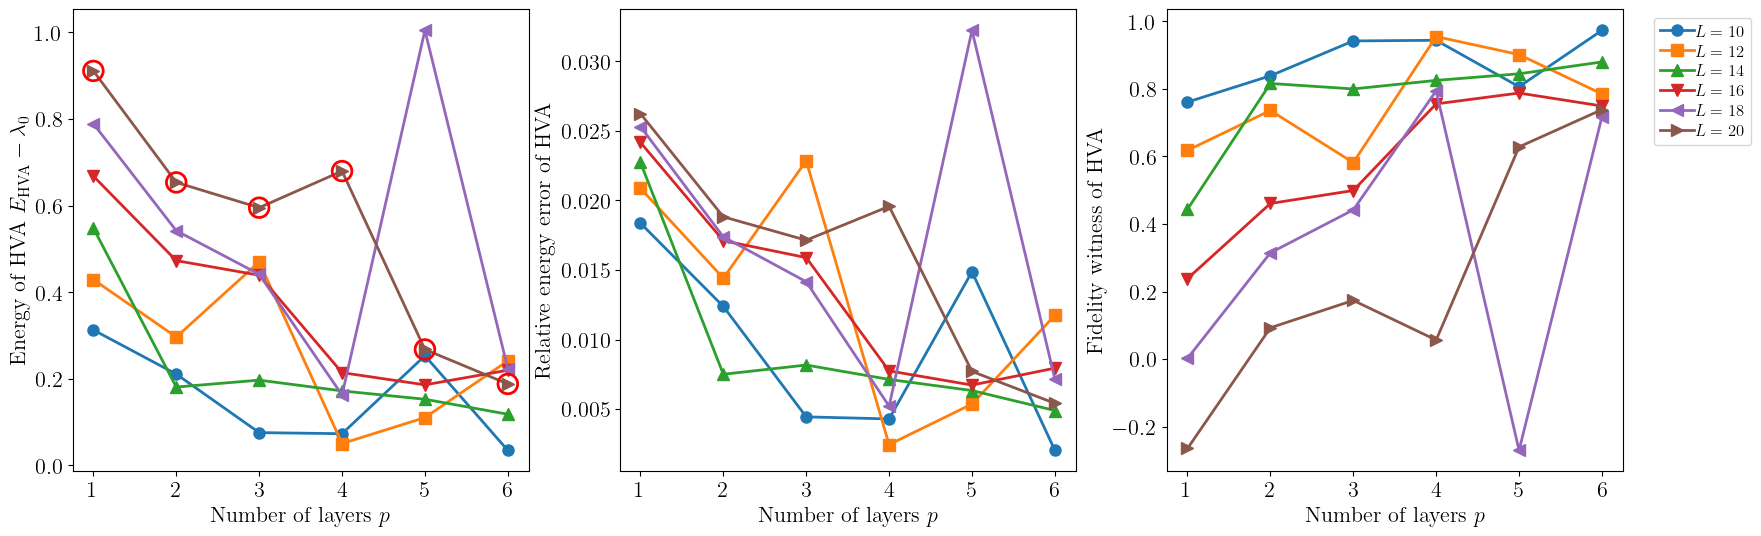

In [36]:
from db_doi.utils_reporting import run_param_rc, load_data, loading_simulation_data_path
run_param_rc(16)
E_HVA_L = HVA_energies['E_HVA_L']
E0_L = HVA_energies['E0_L']
F_W_L = HVA_energies['F_W_L']
fig, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 6), 
                                     gridspec_kw={"width_ratios": [1, 1,1], "height_ratios": [1]})
markers = ['o', 's', '^', 'v', '<', '>', 'd']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i,L in enumerate(HVA_energies['Ls'][2:]):
        
        steps = [1,2,3,4,5,6]
        ax0.plot(steps, E_HVA_L[L]-E0_L[L], color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
        ax0.set_xlabel(r"Number of layers $p$")
        ax0.set_ylabel(r"Energy of HVA $E_{\mathrm{HVA}}-\lambda_0$")

        ax1.plot(steps, abs(E_HVA_L[L]- E0_L[L])/abs(E0_L[L]), color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
        ax1.set_xlabel(r"Number of layers $p$")
        ax1.set_ylabel(r"Relative energy error of HVA")

        ax2.plot(steps, F_W_L[L], color=colors[i], marker=markers[i], linestyle='solid', label = rf"$L={L}$")
        ax2.set_xlabel(r"Number of layers $p$")
        ax2.set_ylabel(r"Fidelity witness of HVA")       
        ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


for p,E  in zip(steps, E_HVA_L[20]):
        ax0.scatter(p,E-E0_L[selection["L"]],
                facecolors='none',   # No fill inside the circle
                edgecolors='red',    # Red outline for the circle
                marker='o',          # Circle marker
                s=200,               # Size of the circle (adjust as needed)
                linewidth=2,         # Thickness of the circle's outline
                zorder=5)            # Ensure it's drawn on top
plt.savefig("pdfs_figures/HVA_overview.pdf")

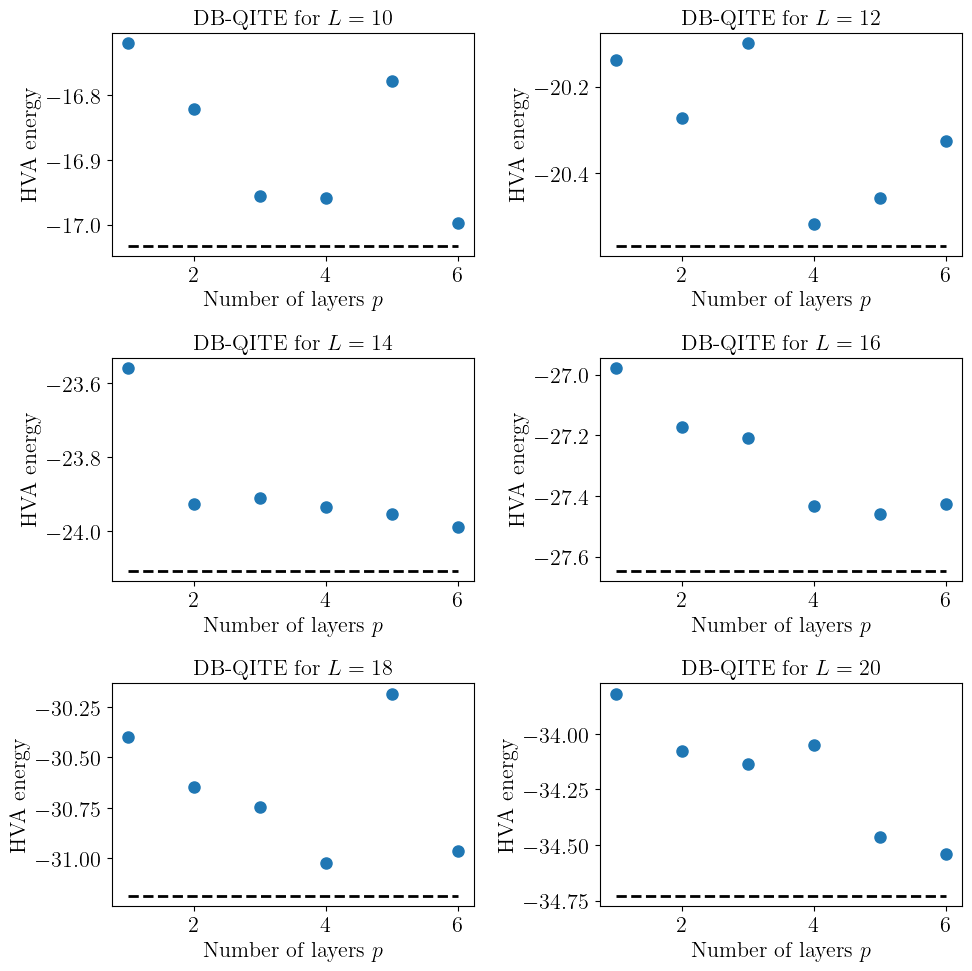

In [ ]:

# Create a figure with 6 subplots (3 rows, 2 columns)
fig, ((ax_10, ax_12), 
      (ax_14, ax_16), 
      (ax_18, ax_20)) = plt.subplots(3, 2, figsize=(10, 10), 
                                     gridspec_kw={"width_ratios": [1, 1], "height_ratios": [1,1,1]})
def plot_HVA_results(ax,L):
        steps = [1,2,3,4,5,6]
        ax.plot(steps, E_HVA_L[L], 'o', label=f'Nlayers={nlayers}')
        ax.plot(steps, [E0_L[L]]*6, 'k--', label='E0')   
        ax.set_xlabel(r"Number of layers $p$")
        ax.set_ylabel(r"HVA energy")
        #ax.set_xticks(ticks = range(0, 6, 1))
        #ax.set_yticks(ticks = [-30,-31,-32,-33, -34,-35])
        #ax.legend(loc="center right", fontsize=15)
        ax.set_title(f"DB-QITE for $L={L}$")
plot_HVA_results(ax_10, 10)
plot_HVA_results(ax_12, 12)
plot_HVA_results(ax_14, 14)
plot_HVA_results(ax_16, 16)
plot_HVA_results(ax_18, 18)
plot_HVA_results(ax_20, 20)

plt.tight_layout()
#plt.savefig("plots/QITE_Heisenberg.pdf")
plt.show()

